# Music auto-tagging, classification, and embedding extraction
In this tutorial, we use Essentia's TensorFlow integration to perform auto-tagging, classification, and embedding extraction.


## Setup
First of all, notice that the default Essentia's `pip` package does not include TensorFlow support.
Currently, this is only available through `pip` for Linux with Python `>=3.5` and `<=3.7`.


In [20]:
!pip install -q essentia-tensorflow

Alternatively, you can follow the instructions in this [blog post](https://mtg.github.io/essentia-labs/news/tensorflow/2019/10/19/tensorflow-models-in-essentia/) to build Essentia with TensorFlow support. This approach also works in Mac, for Python `>=3.8` or with TensorFlow `>=2.0`.


After this step, we can import the required packages.

In [1]:
import json

from essentia.standard import MonoLoader, TensorflowPredictMusiCNN, TensorflowPredictVGGish
import numpy as np
import matplotlib.pyplot as plt

The [Essentia models](https://essentia.upf.edu/models.html)' site contains models for diverse purposes.
Each model comes with a `.json` metadata file with information such as the classes it can predict, the metrics achieved on training, or the model's version.

Let's download the `MusiCNN` auto-tagging model trained on the Million Song Dataset.

In [22]:
!wget -q https://essentia.upf.edu/models/autotagging/msd/msd-musicnn-1.pb
!wget -q https://essentia.upf.edu/models/autotagging/msd/msd-musicnn-1.json

We can open the metadata file and check all the available keys.

In [23]:
with open('msd-musicnn-1.json', 'r') as json_file:
    metadata = json.load(json_file)

print(metadata.keys())

dict_keys(['name', 'type', 'link', 'version', 'description', 'author', 'email', 'release_date', 'framework', 'framework_version', 'classes', 'model_types', 'dataset', 'schema', 'citation'])


Finally, we load an audio file to use as an example.

In [3]:
audio_file = '../../../test/audio/recorded/techno_loop.wav'
audio = MonoLoader(sampleRate=16000, filename=audio_file)()

## Auto-tagging
Now we have all the ingredients to perform auto-tagging with `MusiCNN`.
`TensorflowPredictMusiCNN` is our dedicated algorithm to make predictions with models expecting `MusiCNN`'s mel-spectrogram signature.
We have to configure the `graphFilename` parameter with the path to the model and feed the algorithm with audio sampled at 16kHz. 
The output is a two-dimensional matrix `[time, activations]`.

In [25]:
activations = TensorflowPredictMusiCNN(graphFilename='msd-musicnn-1.pb')(audio)

Finally, we use `matplotlib` to plot the activations.

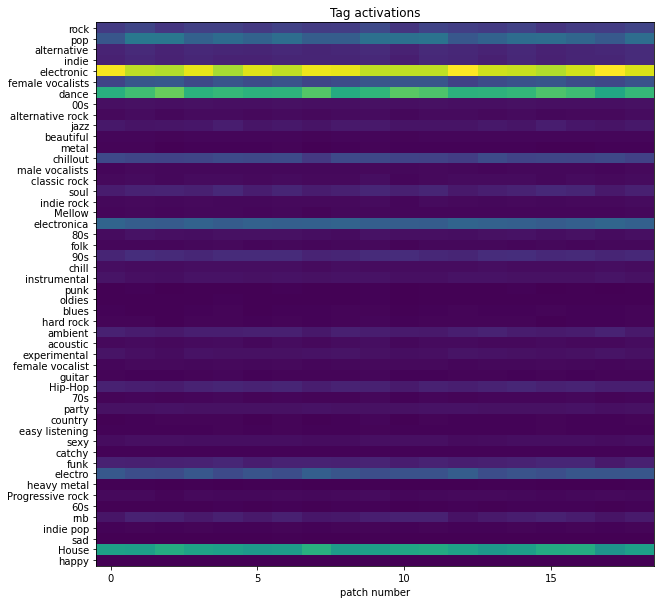

In [26]:
ig, ax = plt.subplots(1, 1, figsize=(10, 10))
ax.matshow(activations.T, aspect='auto')

ax.set_yticks(range(len(metadata['classes'])))
ax.set_yticklabels(metadata['classes'])
ax.set_xlabel('patch number')
ax.xaxis.set_ticks_position('bottom')
plt.title('Tag activations')
plt.show()

## Classification with the transfer learning classifiers
Essentia is shipped with a collection of single-label classifiers based on transfer learning that rely on our auto-tagging models or other deep embedding extractors.
You can read our [blog post](https://mtg.github.io/essentia-labs/news/tensorflow/2020/01/16/tensorflow-models-released/) for a complete list of the available classifiers.

In this example, we use the `danceability` classifier based on the `VGGish` model.

In [27]:
!wget -q https://essentia.upf.edu/models/classifiers/danceability/danceability-vggish-audioset-1.pb
!wget -q https://essentia.upf.edu/models/classifiers/danceability/danceability-vggish-audioset-1.json

We use the `TensorflowPredictVGGish` algorithm because it generates the required mel-spectrogram signature for this case, but if we wanted to use the `danceability` classifier based on `MusiCNN` we should use `TensorflowPredictMusiCNN` again.

In [28]:
with open('danceability-vggish-audioset-1.json', 'r') as json_file:
    metadata = json.load(json_file)

activations = TensorflowPredictVGGish(graphFilename='danceability-vggish-audioset-1.pb')(audio)

Finally, we can compute the global accuracy as the mean of the activations along the temporal axis.

In [29]:
for label, probability in zip(metadata['classes'], activations.mean(axis=0)):
    print(f'{label}: {100 * probability:.1f}%')

danceable: 99.8%
not_danceable: 0.2%


## Embedding extraction
A usual transfer learning approach consists of extracting low-dimensional feature maps from one of the last layers of a pre-trained model as embeddings for a new downstream task.
The metadata includes a field `schema` with the names of the most relevent layers of each model, including layers that are suitable for embedding extraction.


In [2]:
with open('msd-musicnn-1.json', 'r') as json_file:
    metadata = json.load(json_file)

print(metadata['schema'])

{'inputs': [{'name': 'model/Placeholder', 'type': 'float', 'shape': [187, 96]}], 'outputs': [{'name': 'model/Sigmoid', 'type': 'float', 'shape': [1, 50], 'op': 'Sigmoid'}, {'name': 'model/dense_1/BiasAdd', 'type': 'float', 'shape': [1, 50], 'op': 'fully connected', 'description': 'logits'}, {'name': 'model/dense/BiasAdd', 'type': 'float', 'shape': [1, 200], 'op': 'fully connected', 'description': 'embeddings'}]}


From this, we see that `model/dense_1/BiasAdd` is the recommended layer for embeddings.
Additionally, an external tool such as [Netron](https://netron.app/) can be used to inspect the model and get the information about the whole architecture.

`TensorflowPredictMusiCNN` offers an `output` parameter that can be configured to select the layer of the model to retrieve.

In [4]:
embeddings = TensorflowPredictMusiCNN(graphFilename='msd-musicnn-1.pb', output='model/dense_1/BiasAdd')(audio)

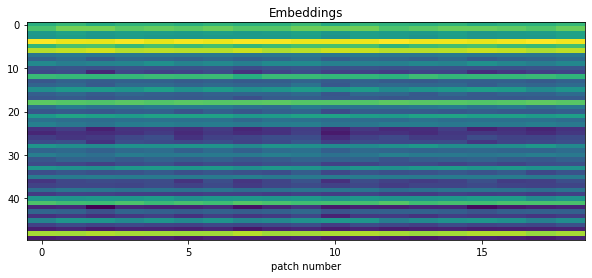

In [5]:
ig, ax = plt.subplots(1, 1, figsize=(10, 4))
ax.matshow(embeddings.T, aspect='auto')
ax.xaxis.set_ticks_position('bottom')
ax.set_xlabel('patch number')
plt.title('Embeddings')
plt.show()